# Human Activity Recognition with Smartphones - Data Analysis

***

## Contents
1. [Overview](#1)
2. [Data](#2)
3. [Static Activities](#3)
4. [Dynamic Activities](#4)
5. [T-SNE Visualisations](#5)
6. [Conclusion](#6)

***

<a id = '1'></a>
## 1. Overview
In this notebook we will be analysing smartphone data and collected from an experiment and exploring what kind of information can be retrieved from the dataset.

***

<a id = '2'></a>
## 2. Data
The data used in this notebook can be found [here](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones), which were collected by using the accelerometer and gyroscope of a smartphone.

>**Description of experiment** <br><br>
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKINGUPSTAIRS, WALKINGDOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.<br><br>
The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import both datasets and merge into one dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = pd.concat([train, test])

# Check null
print(df.isnull().any().sum())

0


From the description of the dataset we can find information of the features.

>**Attribute information**<br><br>
For each record in the dataset the following is provided:<br><br>
    - Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.<br><br>
    - Triaxial Angular velocity from the gyroscope.<br><br>
    - A 561-feature vector with time and frequency domain variables.<br><br>
    - Its activity label.<br><br>
    - An identifier of the subject who carried out the experiment.


In [3]:
# Group and count column names
print(pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False))

# Total number of features
print('Total number of features: ',len(df.columns))

                      count
fBodyAcc                 79
fBodyGyro                79
fBodyAccJerk             79
tGravityAcc              40
tBodyAcc                 40
tBodyGyroJerk            40
tBodyGyro                40
tBodyAccJerk             40
tBodyAccMag              13
tGravityAccMag           13
tBodyAccJerkMag          13
tBodyGyroMag             13
tBodyGyroJerkMag         13
fBodyAccMag              13
fBodyBodyAccJerkMag      13
fBodyBodyGyroMag         13
fBodyBodyGyroJerkMag     13
angle                     7
subject                   1
Activity                  1
Total number of features:  563


Looking at the feature columns we find 'Acc' and 'Gyro columns in the XYZ axes and their corresponding 'Mag' which refers to the magnitude of the resulting vectors. 'angle' columns represents the difference in angle between the XYZ axes and the 3D vectors recorded by the sensors.

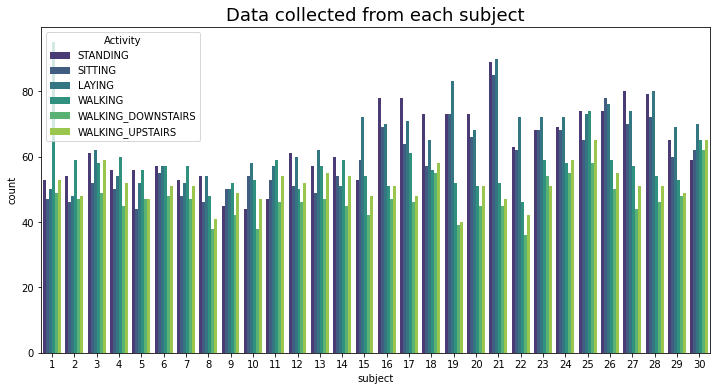

In [4]:
# Check amount of data collected from each subject
plt.figure(figsize = (12,6))
plt.title('Data collected from each subject', fontsize = 18)
sns.countplot(x = 'subject', hue = 'Activity', data = df, palette = 'viridis')
plt.show()

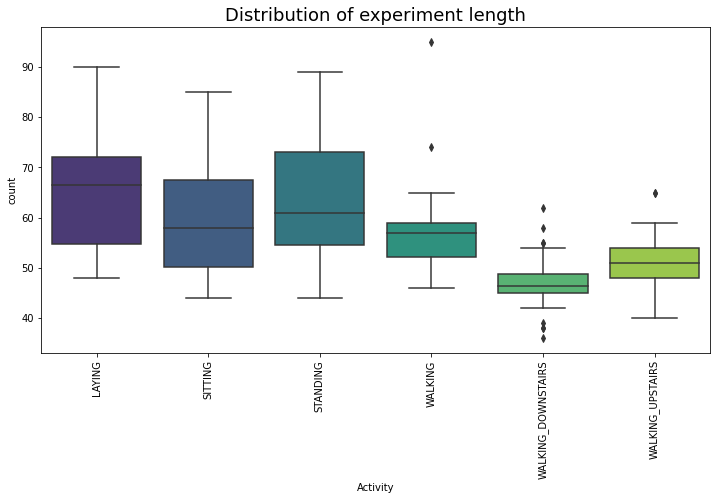

In [5]:
# Box plot for length of experiment
plt.figure(figsize = (12,6))
plt.title('Distribution of experiment length', fontsize = 18)
sns.boxplot(x = 'Activity', y ='angle(Z,gravityMean)', data = df.groupby(['subject','Activity'])['angle(Z,gravityMean)'].count().reset_index(level=[1]), palette = 'viridis')
plt.ylabel('count')
plt.xticks(rotation = 90)
plt.show()

From the description of the dataset we know that each datapoint spans 2.56s with a 50% overlap which means that each datapoint advances time by 1.28s. Looking at the plots above we can conclude that the length of the experiment for each subject varies, with the average length of each part taking about 50-60 time steps. 

For the dynamic activities, this suggests that the subjects were tasked to walk/climb a certain distance rather than for a certain length of time. Additionally, walking downstairs takes less time than walking upstairs for a majority of the subjects.

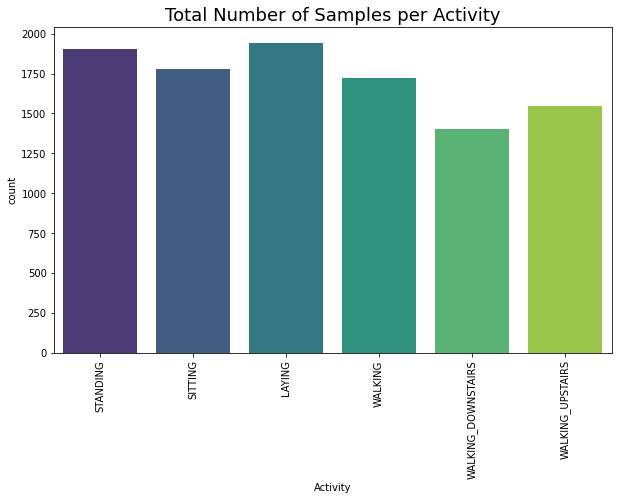

In [6]:
# Total class imbalance
plt.figure(figsize = (10,6))
plt.title('Total Number of Samples per Activity', fontsize = 18)
sns.countplot(df.Activity, palette = 'viridis')
plt.xticks(rotation = 90)
plt.show()

Looking at total sampels collected for each activity we observe that as seen before, walking downstairs takes less time than walking upstairs. In terms of class imbalance the samples collected for the activities are relatively balanced.

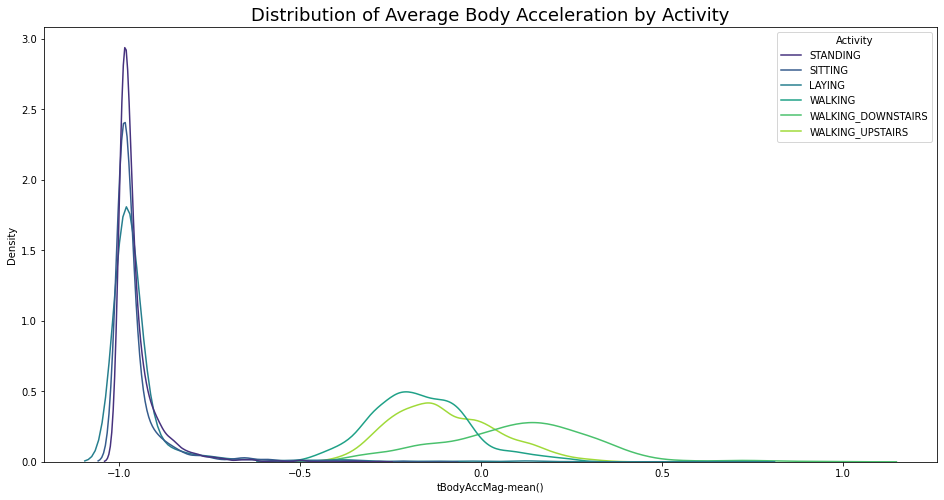

In [7]:
# Static vs Dynamic Activities
plt.figure(figsize = (16,8))
plt.title('Distribution of Average Body Acceleration by Activity', fontsize = 18)
sns.kdeplot(x = 'tBodyAccMag-mean()', data = df, hue = 'Activity', palette = 'viridis')
plt.show() # Stationary and moving activities are clearly separable

Looking at the distribution of body acceleration magnitude observations for each of the activities we see that just from this one feature the static and dynamic activities can be clearly separated, suggesting that it will be trivial to identify whether the person carrying the phone is in motion.

***

<a id = '3'></a>
## 3. Static Activities

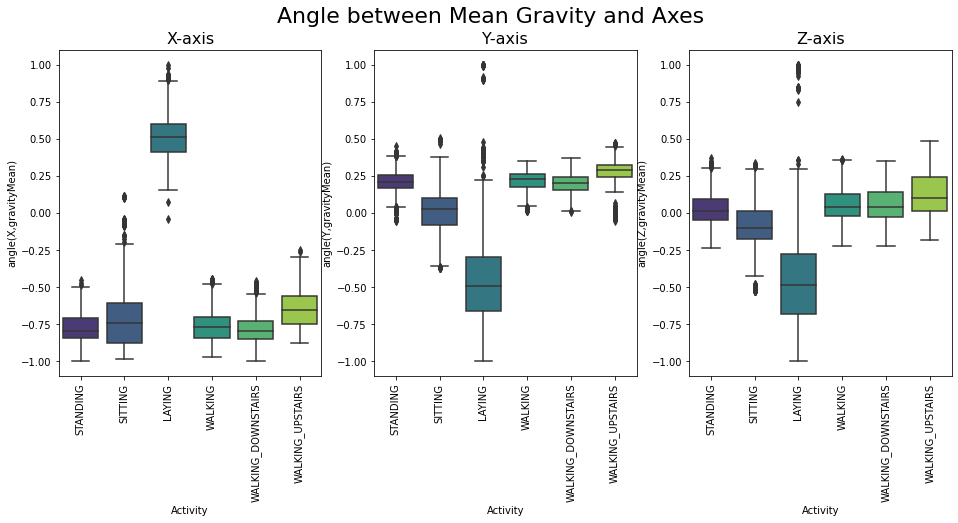

In [8]:
# Plot Recorded Angle Between Gravity and Axes to Separate Activities
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,6))
plt.suptitle('Angle between Mean Gravity and Axes', fontsize = 22)

ax1.set_title('X-axis', fontsize = 16)
sns.boxplot(y = 'angle(X,gravityMean)', data = df, x = 'Activity', palette = 'viridis', ax = ax1)
ax1.tick_params(axis = 'x', labelrotation = 90)

ax2.set_title('Y-axis', fontsize = 16)
sns.boxplot(y = 'angle(Y,gravityMean)', data = df, x = 'Activity', palette = 'viridis', ax = ax2)
ax2.tick_params(axis = 'x', labelrotation = 90)

ax3.set_title('Z-axis', fontsize = 16)
sns.boxplot(y = 'angle(Z,gravityMean)', data = df, x = 'Activity', palette = 'viridis', ax = ax3)
ax3.tick_params(axis = 'x', labelrotation = 90)

plt.show()

Looking at the angles recorded between mean gravity vector and the three axes, we see that "LAYING" is clearly separable from the other activities.

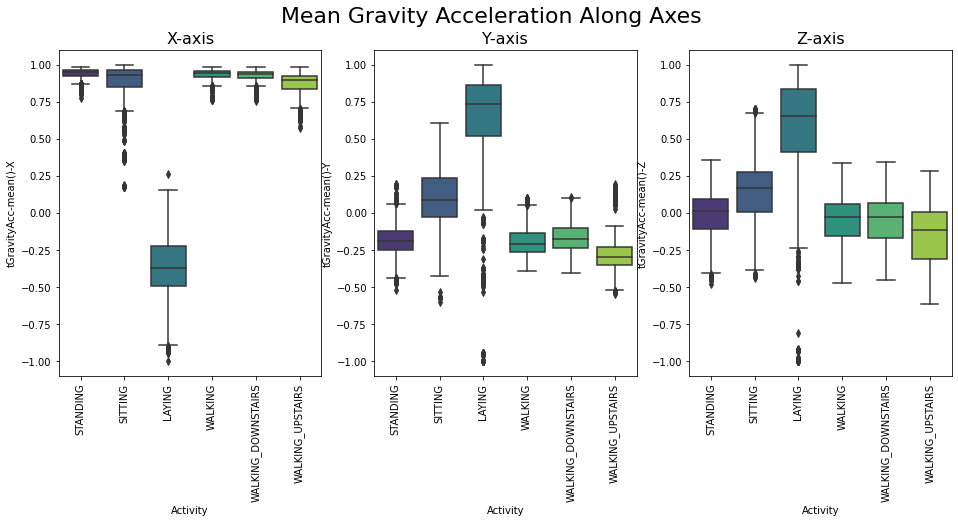

In [9]:
# Plot Recorded Angle Between Gravity and Axes to Separate Activities
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,6))
plt.suptitle('Mean Gravity Acceleration Along Axes', fontsize = 22)

ax1.set_title('X-axis', fontsize = 16)
sns.boxplot(y = 'tGravityAcc-mean()-X', data = df, x = 'Activity', palette = 'viridis', ax = ax1)
ax1.tick_params(axis = 'x', labelrotation = 90)

ax2.set_title('Y-axis', fontsize = 16)
sns.boxplot(y = 'tGravityAcc-mean()-Y', data = df, x = 'Activity', palette = 'viridis', ax = ax2)
ax2.tick_params(axis = 'x', labelrotation = 90)

ax3.set_title('Z-axis', fontsize = 16)
sns.boxplot(y = 'tGravityAcc-mean()-Z', data = df, x = 'Activity', palette = 'viridis', ax = ax3)
ax3.tick_params(axis = 'x', labelrotation = 90)

plt.show()

Similarly, looking at the acceleration recorded along each axis shows a similar pattern where "LAYING" is clearly separable while "STANDING" and "SITTING" are not as separable except along the y-axis. Measurements from dynamic activities in general spans a smaller range as the phone is held in the same orientation throughout the three walking activities.

One thing to note is that in the experiment the phone is held within a pouch tied to the waist. This means that across most activities these two measurements will not change drastically as the phone is held in the same orientation, this is evident from all activities other than "LAYING" occupying a similar range of measurements. If the phone was carried in the front pocket of the subject's pants instead we will see drastically different readings across the activities as the orientation of the phone changes between each activity (e.g. "STANDING" will make the phone screen more perpendicular to the ground while "SITTING" will make it more parallel to the ground.)

In the dataset "SITTING" measurements spans a larger range than "STANDING". We can assume that this is due to differences in how the subjects sit on the chair provided (e.g. relaxed laying back, upright, slouching, etc.). This results in greater variance on phone orientation compared to the "STANDING" position.

***

<a id = '4'></a>
## 4. Dynamic Activities

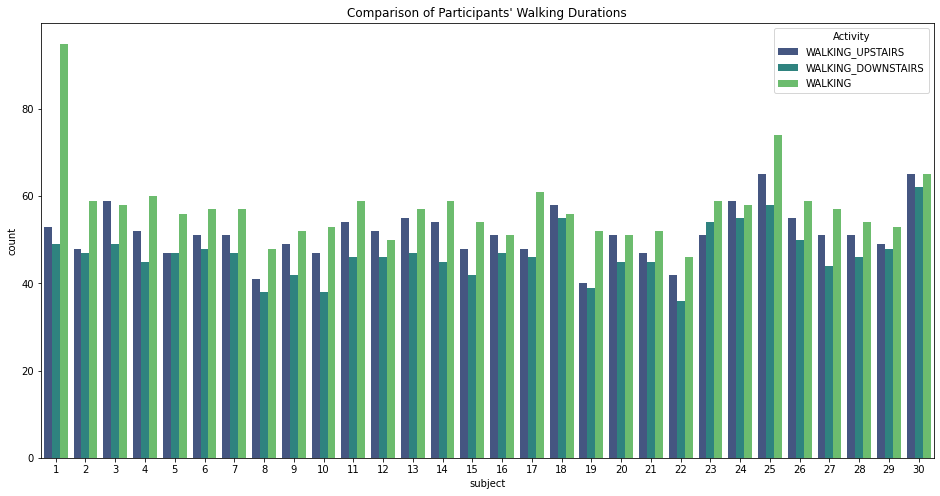

In [10]:
# Difference in walking duration
plt.figure(figsize = (16,8))
plt.title('Comparison of Participants\' Walking Durations')
sns.countplot(x = 'subject', hue = 'Activity', data = df.loc[df.Activity.isin(['WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','WALKING'])], palette = 'viridis', hue_order = ['WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','WALKING'])
plt.show()

Almost all subjects show the same pattern of "WALKING_DOWNSTAIRS" < "WALKING_UPSTAIRS" < "WALKING" in terms of walking duration.

Through Singular-Spectrum Analysis (SSA), we can extract extract main components of the walking patterns of each subject using only the euclidean norm of acceleration.

In [11]:
# Euclidean norm of acceleration of subject "1"
cols = ['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z']

walking = df[(df.Activity == 'WALKING')&(df.subject == 1)][cols].reset_index(drop=True)
acceleration = (walking**2).sum(axis = 1)**0.5
accel = pd.DataFrame()
j = 0
k = int(len(acceleration)/19)
for i in range(9):
    accel[str(i)] = acceleration[j:k+35].reset_index().iloc[:,1]
    j += int(len(acceleration)/19)
    k += int(len(acceleration)/19)
accel_ = np.transpose(accel.to_numpy())

To obtain the euclidean norm for acceleration we can simply use the accelerometer measurements from the three axes in this equation

$$||x||^2 = \sqrt{X^2 + Y^2 + Z^2}$$

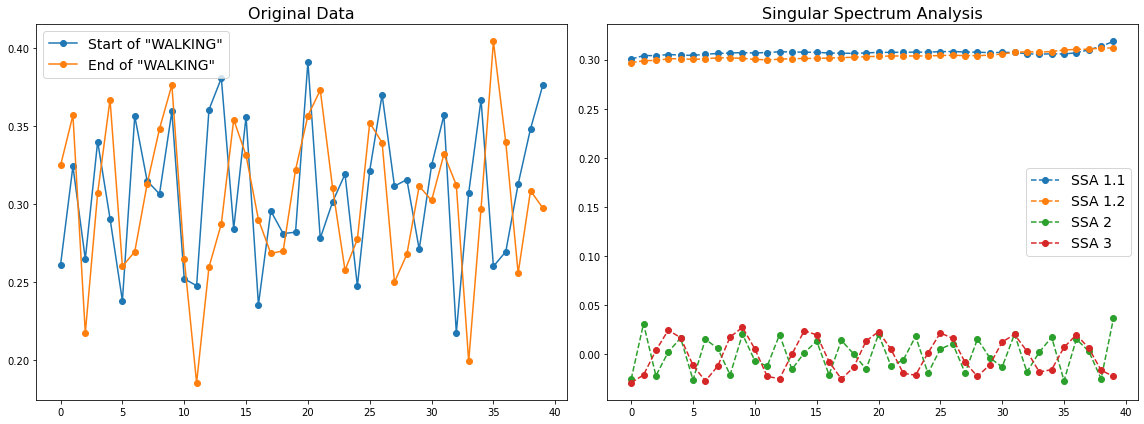

In [12]:
# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=20, groups = None)
X_ssa = ssa.fit_transform(accel_)

# Show the results for the first time series and its subseries
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16, 6))

ax1.set_title('Original Data', fontsize = 16)
ax1.plot(accel_[1], 'o-', label='Start of "WALKING"')
ax1.plot(accel_[7], 'o-', label='End of "WALKING"')
ax1.legend(loc='best', fontsize=14)

ax2.set_title('Singular Spectrum Analysis', fontsize = 16)
ax2.plot(X_ssa[1, 0], 'o--', label='SSA 1.1')
ax2.plot(X_ssa[7, 0], 'o--', label='SSA 1.2')
ax2.plot(X_ssa[1, 1], 'o--', label='SSA 2')
ax2.plot(X_ssa[7, 1], 'o--', label='SSA 3')
ax2.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.show()

The above plots are from subject "1"'s "WALKING" data, specifically time windows of 40 time steps near the start and end of the sample's measurements. The data decomposes into four different components. SSA 1.1 and SSA 1.2 shows the overall constant trends of the two time windows from the original data while SSA 2 and SSA 3 appears to show the walking frequencies of the subject within these two windows.

SSA 2 having almost double the frequency of SSA 3 may suggest that the "WALKING" activity was split into at least two sections, one where the subject walks at a faster pace while a slower pace for the other section.

***

<a id = '5'></a>
## 5. T-SNE Visualisations

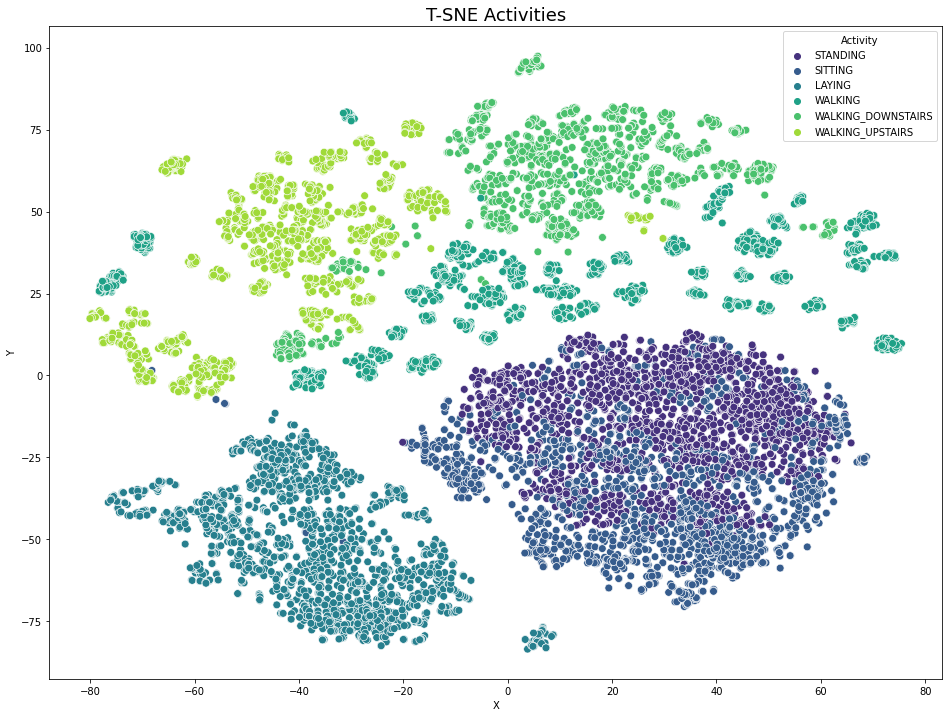

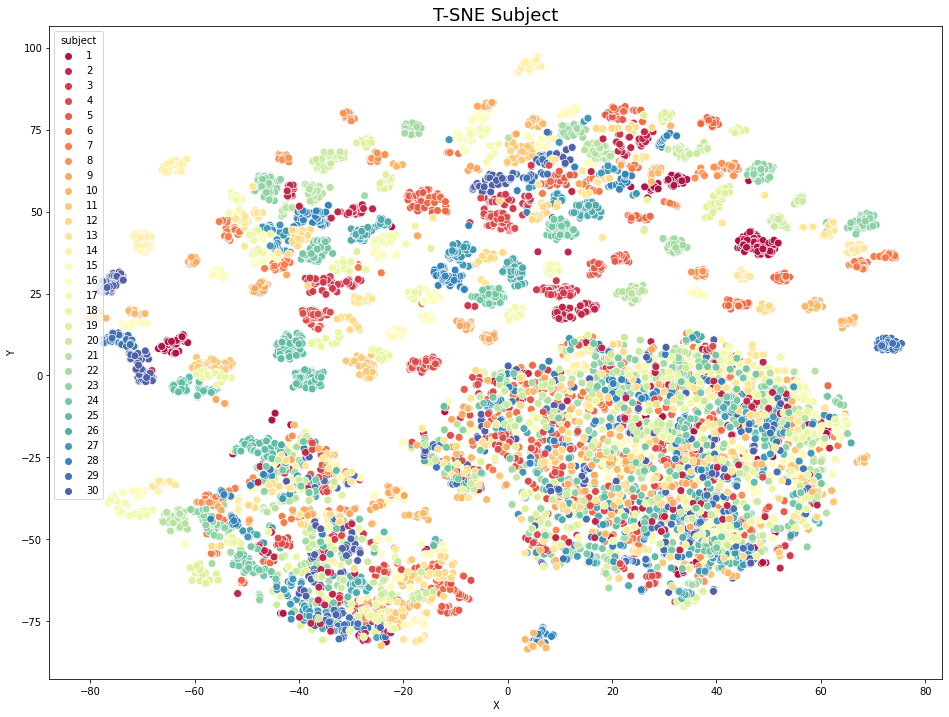

In [13]:
# Activities
tsne = TSNE(verbose = 0)
tsne_arr = tsne.fit_transform(df.drop(['subject','Activity'],axis =1))
tsne_df = pd.DataFrame(tsne_arr)
tsne_df.columns = ['X','Y']
tsne_df['Activity'] = df.Activity.reset_index()['Activity']

plt.figure(figsize = (16,12))
plt.title('T-SNE Activities', fontsize = 18)
sns.scatterplot(x = 'X', y = 'Y', hue = 'Activity', data = tsne_df, palette = 'viridis', s = 60)
plt.show() # Only STANDING and SITTING are not separable

# Subjects
tsne_df['subject'] = df.subject.reset_index()['subject']

custom_palette = sns.color_palette('Spectral', 30)

plt.figure(figsize = (16,12))
plt.title('T-SNE Subject', fontsize = 18)
sns.scatterplot(x = 'X', y = 'Y', hue = 'subject', data = tsne_df, palette = custom_palette, s = 60)
plt.show() # Seems like subjects can be identified by their dynamic activity (walking style)


Using TSNE to visualise the high dimensional data we see that the six activities are clearly separable except for "STANDING" and "SITTING" where we can see some overlap. Looking at the TSNE plot for the subjects we see that the static activities are not clearly separable while the dynamic activities appear to be separable except for "WALKING_DOWNSTAIRS". This suggests that using just the accelerometer and gyroscope, the smartphone may be able to identify the person currently holding the phone.

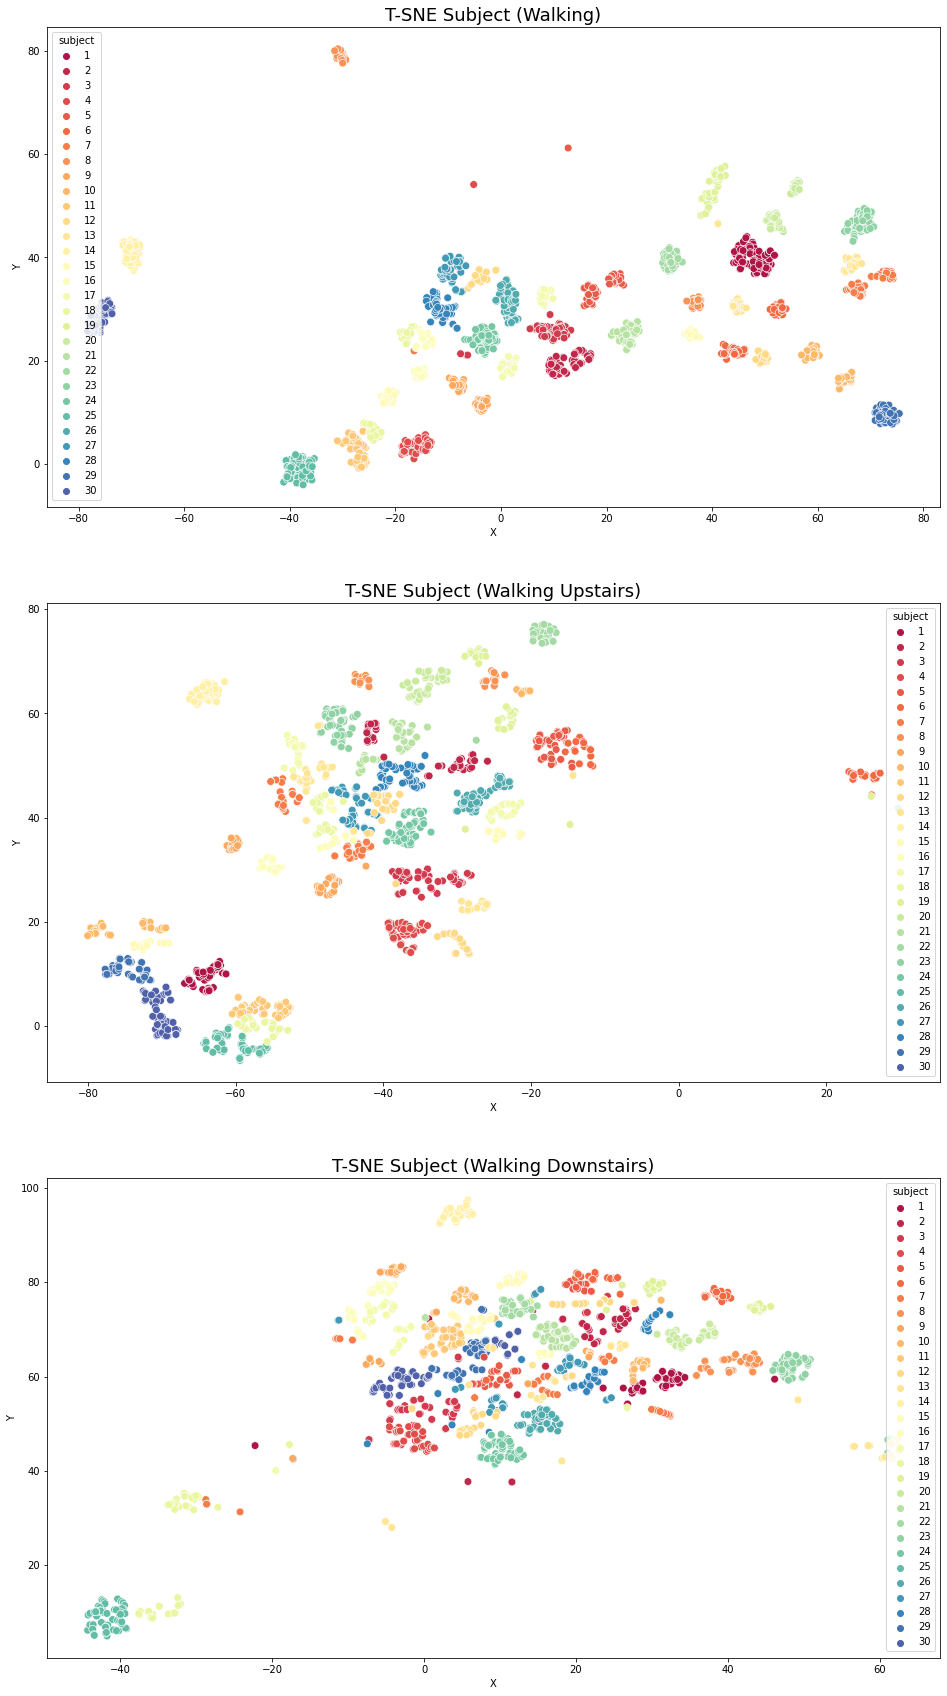

In [14]:
# Subjects
fig, (ax1,ax2,ax3) = plt.subplots(3,1 ,figsize = (16,30))

ax1.set_title('T-SNE Subject (Walking)', fontsize = 18)
sns.scatterplot(x = 'X', y = 'Y', hue = 'subject', data = tsne_df.loc[tsne_df.Activity == 'WALKING'], ax = ax1, palette = custom_palette, s = 60)

ax2.set_title('T-SNE Subject (Walking Upstairs)', fontsize = 18)
sns.scatterplot(x = 'X', y = 'Y', hue = 'subject', data = tsne_df.loc[tsne_df.Activity == 'WALKING_UPSTAIRS'], ax = ax2, palette = custom_palette, s = 60)

ax3.set_title('T-SNE Subject (Walking Downstairs)', fontsize = 18)
sns.scatterplot(x = 'X', y = 'Y', hue = 'subject', data = tsne_df.loc[tsne_df.Activity == 'WALKING_DOWNSTAIRS'], ax = ax3, palette = custom_palette, s = 60)

plt.show() 

Looking at TSNE plots of each dynamic activity individually, we see that for "WALKING" and "WALKING_UPSTAIRS" most of the subjects are clearly separable, while more overlaps between clusters can be observed in "WALKING_DOWNSTAIRS". This may be due to the less controlled manner of walking downstairs some people may have, resulting in less characteristic measurements from the sensors.

From the plots above, it can be assumed that machine learning models made to identify "Activity" for all subjects and "subject" for the dynamic activities will perform well.

***

<a id = '6'></a>
## 6. Conclusion
In this notebook we have explored a data set containing measurements from a smartphone's accelerometer and gyroscope. Just from these two sensors alone we have shown that the phone has the potential to both identify the individual currently in possession of the phone and the activity that is being performed. 

A continuation of this notebook can be found [here](https://github.com/wenhao7/Data-Science/blob/main/Human%20Activity%20Recognition%20with%20Smartphones/Human%20Activity%20Recognition%20with%20Smartphones%20-%20Classification.ipynb) where machine learning models will be trained to classify the activities and subjects within the dataset.